# Follow these instructions:

Once you are finished, ensure to complete the following steps.

1.  Restart your kernel by clicking 'Kernel' > 'Restart & Run All'.

2.  Fix any errors which result from this.

3.  Repeat steps 1. and 2. until your notebook runs without errors.

4.  Submit your completed notebook to OWL by the deadline.

## Assignment Week 8: Text Mining using Dimensionality Reduction Methods [_/100 Marks]

This dataset comes from the #TidyTuesday repository and represents 2122 TV shows. In this assignment, we will apply dimensionality reduction methods to improve our understanding of text data and to predict the number of seasons of the TV shows. 

In [1]:
import numpy as np
import pandas as pd
#!pip3 install umap-learn
import umap
from scipy.sparse import csr_matrix
from sklearn.decomposition import PCA, TruncatedSVD
import sklearn.feature_extraction.text as sktext
from sklearn.linear_model import LogisticRegressionCV
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_curve, roc_auc_score, auc
import xgboost as xgb
from sklearn.model_selection import StratifiedKFold
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
from itertools import product

import seaborn as sns
import matplotlib.pyplot as plt
seed = 0

/home/farhad-bat/.local/lib/python3.8/site-packages/numba/core/errors.py:175: UserWarning: Insufficiently recent colorama version found. Numba requires colorama >= 0.3.9
  warnings.warn(msg)
/home/farhad-bat/.local/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
[nltk_data] Downloading package stopwords to /home/farhad-
[nltk_data]     bat/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


## Task 1: Decomposition of the texts [ /66 marks]

### Question 1.1

The dataset comes with the a few text variables and a categorical variable which represents whether a TV show has one season or more than one season. Import the data and create a new variable called 'full_description' by combining the three columns title, listed_in, and description. Keep the two columns,'duration' and 'full_description', and remove the rest. Do binary encoding for the traget variable 'duration'. Assign 1 to 'More than one season' and 0 to 'One season'. In the "full_description" column replace the word "Sci-Fi" with the word "Sci_Fi" since we would want to treat "Sci-Fi" as single word. Select the full_description column and display its first 10 rows. Use sklearn's `TfidfVectorizer` to eliminate accents, special characters, and stopwords (please see below to find out what stopwords need to be removed). In addition, make sure to eliminate words that appear in less than 5% of documents and those that appear in over 95%. You can also set `sublinear_tf` to `True`. After that, split the data into train and test with `test_size = 0.2` and `seed = seed`. Calculate the [Tf-Idf transform](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfTransformer.html) for both train and test. Note that you need to fit and transform the inputs for the train set but you only need to transform the inputs for the test set. Don't forget to turn the sparse matrices to dense ones after you apply the `Tf-Idf` transform.  

In [2]:
# Load the data [ /1 mark]
# read csv
data_set = pd.read_csv(filepath_or_buffer='Netflix_data.csv')
# rename unnamed column to title column
data_set = data_set.rename(columns={'Unnamed: 0':'title'})

# Create a new variable called 'full_description' by combining the three columns title, listed_in, and description [ /2 marks]
# use an empty space to concat these three columns
data_set['full_description'] = data_set['title'] + ' ' + data_set['listed_in']+ ' ' + data_set['description']

# Keep two columns,'duration' and 'full_description', and remove the rest
data_set = data_set[['full_description', 'duration']]

# Do binary encoding for the traget variable 'duration'. Assign 1 to 'More than one season' and 0 to 'One season' [ \1 mark]
data_set['duration'] = data_set['duration'].replace({'One season': 0, 'More than one season': 1}).astype(np.int64)

# In the "full_description" column replace the word "Sci-Fi" with the word "Sci_Fi" [ \1 mark]
data_set['full_description'] = data_set['full_description'].apply(lambda row: row.replace('Sci-Fi', 'Sci_Fi')) 

# Select the following column and display its first 10 rows: full_description [ /1 mark]
data_set['full_description'].head(10)

0    3% International TV Shows, TV Dramas, TV Sci_F...
1    46 International TV Shows, TV Dramas, TV Myste...
2    1983 Crime TV Shows, International TV Shows, T...
3    1994 Crime TV Shows, Docuseries, International...
4    ​SAINT SEIYA: Knights of the Zodiac Anime Seri...
5    (Un)Well Reality TV This docuseries takes a de...
6    #blackAF TV Comedies Kenya Barris and his fami...
7    Şubat Crime TV Shows, International TV Shows, ...
8    100 Days My Prince International TV Shows, Rom...
9    100 Humans Docuseries, Science & Nature TV One...
Name: full_description, dtype: object

In [3]:
# Defining the TfIDFTransformer [ /4 marks]
# Define a vectors of stop words: stop words list must contain 'english' stop words, 'shows', and 'tv' 
stop_words = stopwords.words('english') + ['shows', 'tv']

# Tf-IDF Transformer, remove stop words, remove words that appear less than 5% of documents and those that appear in over 95%
TfIDFTransformer = sktext.TfidfVectorizer(
                        strip_accents='unicode', # Eliminate accents and special characters
                        stop_words=stop_words, # Eliminates stop words.
                        min_df = 0.05, # Eliminate words that do not appear in more than 5% of texts
                        max_df = 0.95, # Eliminate words that appear in more than 95% of texts
                        sublinear_tf=True # Use sublinear weights (softplus), i.e., replace tf with 1 + log(tf)
                      )

# Train/test split [ /2 marks]
train_set, test_set = train_test_split(data_set, test_size=0.2, random_state=seed)
train_set.reset_index(inplace=True)
test_set.reset_index(inplace=True)


# Calculate the Tf-Idf transform [ /2 marks]
# fit and transform train
TfIDF_train = TfIDFTransformer.fit_transform(train_set['full_description'])
TfIDF_train = TfIDF_train.toarray()
TfIDF_train = pd.DataFrame(data=TfIDF_train, columns=TfIDFTransformer.get_feature_names_out())
y_train = train_set['duration']

# transform test
TfIDF_test = TfIDFTransformer.transform(test_set['full_description'])
TfIDF_test = TfIDF_test.toarray() 
TfIDF_test = pd.DataFrame(data=TfIDF_test, columns=TfIDFTransformer.get_feature_names_out())
y_test = test_set['duration']

TfIDF_train.head()

,action,adventure,anime,british,comedies,crime,docuseries,dramas,family,friends,...,love,new,reality,romantic,school,series,spanish,two,world,young
0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.794697,0.0,0.0,...,0.0,0.000000,0.0,0.000000,0.0,0.000000,0.00000,0.0,0.0,0.0
1,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.000000,0.0,0.590184,0.0,0.000000,0.00000,0.0,0.0,0.0
2,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.000000,0.0,0.470905,0.0,0.000000,0.59425,0.0,0.0,0.0
3,0.0,0.0,0.0,0.0,0.385574,0.0,0.0,0.338238,0.0,0.0,...,0.0,0.528965,0.0,0.453455,0.0,0.000000,0.00000,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0,...,0.0,0.000000,0.0,0.000000,0.0,0.845177,0.00000,0.0,0.0,0.0


From here on, you will use the variables `TfIDF_train` and `TfIDF_test` as the input for the different tasks, and the `y_train` and `y_test` labels for each dataset (if required). Print the number of indices in the ouput using [`TfIDFTransformer.get_feature_names()` method](https://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.TfidfTransformer.html).

In [4]:
# Print the number of indices [ /2 marks]
print(TfIDFTransformer.get_feature_names_out())
print('\nNumber of indices in the output: {}'.format(len(TfIDFTransformer.get_feature_names_out())))

['action' 'adventure' 'anime' 'british' 'comedies' 'crime' 'docuseries'
 'dramas' 'family' 'friends' 'international' 'kids' 'korean' 'language'
 'life' 'love' 'new' 'reality' 'romantic' 'school' 'series' 'spanish'
 'two' 'world' 'young']

Number of indices in the output: 25


### Question 1.2
Now we have the TfIDF matrix so we can start working on the data. We hope to explore what some commonly occuring concepts are in the 'full_description' column. We can do this using PCA. A PCA transform of the TF-IDF matrix will give us a basis of the text data, each component representing a *concept* or set of words that are correlated. Correlation in text can be interpreted as a relation to a similar topic. Calculate a PCA transform of the training data using the **maximum** number of concepts possible. Make a plot of the explained variance that shows the cumulative explained variance per number of concepts.


Variance explained by each component:
[0.09362007 0.08413517 0.06187495 0.05820898 0.05399592 0.04738749
 0.04586429 0.04223323 0.03728822 0.03463887 0.03197209 0.02952759
 0.02792669 0.02704396 0.02593713 0.0230286  0.02232388 0.02170416
 0.02078658 0.02001429 0.01697239 0.01349668 0.00391307 0.0032234
 0.00027657]

Cumulative sum of variance explained until each component:
[0.09362007 0.17775524 0.23963019 0.29783917 0.35183509 0.39922258
 0.44508687 0.4873201  0.52460832 0.55924719 0.59121928 0.62074686
 0.64867355 0.67571752 0.70165464 0.72468324 0.74700712 0.76871128
 0.78949785 0.80951214 0.82648453 0.83998121 0.84389428 0.84711767
 0.84739425]

Cumulative sum of ratio of variance explained until each component:
[0.11047995 0.20976687 0.28278478 0.35147651 0.41519646 0.47111788
 0.52524179 0.57508073 0.61908412 0.65996104 0.69769092 0.73253608
 0.76549204 0.7974063  0.8280144  0.85519018 0.88153433 0.90714715
 0.93167715 0.95529577 0.97532469 0.99125196 0.99586973 0.99967362
 1.

Text(0, 0.5, 'Cumulative Ratio Variance Explained')

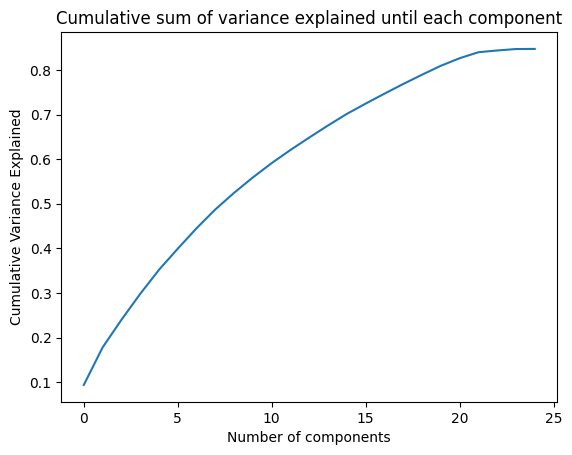

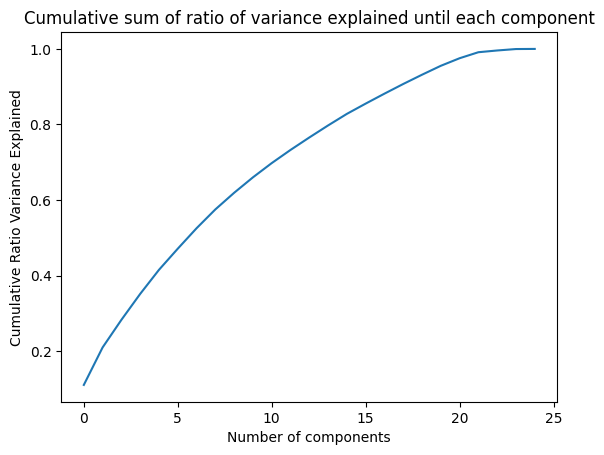

In [5]:
# Apply PCA on training data and get the explained variance [ / 4 marks]
# all components
pca_obj = PCA(n_components=min(TfIDF_train.shape), svd_solver='full')
# fit pca on train
pca_obj.fit(TfIDF_train)

# Plotting explained variance with number of concepts [ / 4 marks]
print('\nVariance explained by each component:')
print(pca_obj.explained_variance_)

print('\nCumulative sum of variance explained until each component:')
cum_sum_variance = np.cumsum(pca_obj.explained_variance_)
print(cum_sum_variance)


print('\nCumulative sum of ratio of variance explained until each component:')
cum_sum_variance_ratio = np.cumsum(pca_obj.explained_variance_ratio_)
print(np.cumsum(pca_obj.explained_variance_ratio_))

plt.figure()
plt.plot([i for i in range(len(cum_sum_variance))], cum_sum_variance)
plt.title('Cumulative sum of variance explained until each component')
plt.xlabel('Number of components')
plt.ylabel('Cumulative Variance Explained')

plt.figure()
plt.plot([i for i in range(len(cum_sum_variance_ratio))], cum_sum_variance_ratio)
plt.title('Cumulative sum of ratio of variance explained until each component')
plt.xlabel('Number of components')
plt.ylabel('Cumulative Ratio Variance Explained')


**Question:** Exactly how many concepts do we need to correctly explain at least 80% of the data?


In [6]:
# To get the exact index where the variance is above 80% [ / 4 marks]
index_comp = np.searchsorted(cum_sum_variance_ratio, 0.8, side='left')
print('Value of cummulative some until component at index [{}] is [{}]'.format(index_comp, cum_sum_variance_ratio[index_comp]))
print('Minimum number of component for reaching 80% is equal to [{}]'.format(index_comp+1))

Value of cummulative some until component at index [14] is [0.8280144010110434]
Minimum number of component for reaching 80% is equal to [15]


**Your Answer: Thes answer is printed in the above block.** 

### Question 1.3

Let's examine the first three concepts by looking how many variance they explained and showing the 10 words that are the most important in each of these three concepts (as revealed by the absolute value of the PCA weight in each concept).


In [7]:
# Explained variance [ / 2 marks]
print('Explained value of variance by each of first three component: {}'.format(pca_obj.explained_variance_[0:3]))
print('Explained ratio of variance by each of first three component: {}'.format(pca_obj.explained_variance_ratio_[0:3]))

print('\nExplained value of variance by all of first three component: {}'.format(np.sum(pca_obj.explained_variance_[0:3])))
print('Explained ratio of variance by all of first three component: {}'.format(np.sum(pca_obj.explained_variance_ratio_[0:3])))


Explained value of variance by each of first three component: [0.09362007 0.08413517 0.06187495]
Explained ratio of variance by each of first three component: [0.11047995 0.09928692 0.0730179 ]

Explained value of variance by all of first three component: 0.23963019271484817
Explained ratio of variance by all of first three component: 0.2827847758017607


In [8]:
# Get 10 most important words for each component [ / 4 marks]
three_abs_component = np.abs(pca_obj.components_[0:3, :])

In [9]:
# Words for concept 1 [ / 2 marks]
top_ten_comp_1_idx = np.argsort(three_abs_component[0])[-10:]
top_ten_comp_1_words = pca_obj.feature_names_in_[top_ten_comp_1_idx]
print('10 words most important in component 1 are: {}'.format(top_ten_comp_1_words))

10 words most important in component 1 are: ['british' 'comedies' 'reality' 'romantic' 'series' 'docuseries' 'crime'
 'international' 'kids' 'dramas']


In [10]:
# Words for concept 2 [ / 2 marks]
top_ten_comp_2_idx = np.argsort(three_abs_component[1])[-10:]
top_ten_comp_2_words = pca_obj.feature_names_in_[top_ten_comp_2_idx]
print('10 words most important in component 2 are: {}'.format(top_ten_comp_2_words))

10 words most important in component 2 are: ['friends' 'romantic' 'dramas' 'series' 'reality' 'british' 'crime' 'kids'
 'comedies' 'docuseries']


In [11]:
# Words for concept 3 [ / 2 marks]
top_ten_comp_3_idx = np.argsort(three_abs_component[2])[-10:]
top_ten_comp_3_words = pca_obj.feature_names_in_[top_ten_comp_3_idx]
print('10 words most important in component 3 are: {}'.format(top_ten_comp_3_words))

10 words most important in component 3 are: ['korean' 'comedies' 'love' 'docuseries' 'international' 'dramas'
 'romantic' 'crime' 'kids' 'reality']


### Question 1.4

 Apply the PCA transformation to the test dataset. Use only the first two components and make a scatter plot of the TV shows. Identify the 'More than one season' TV shows, and 'One season' TV shows by colouring points with different colours. Make sure to add a legend to your plot!

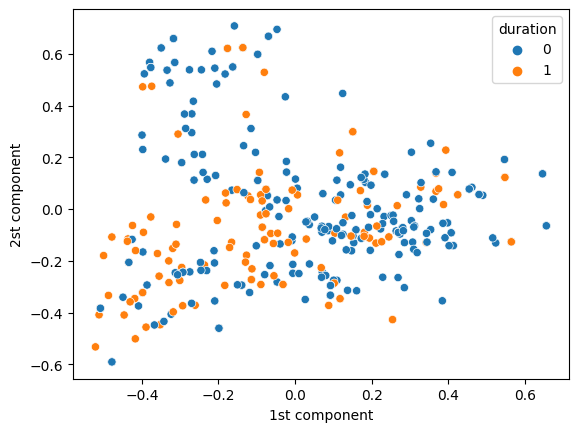

In [12]:
# Apply PCA to the test dataset [ / 2 marks]
TfIDF_test_projected = pca_obj.transform(TfIDF_test)
TfIDF_test_projected = TfIDF_test_projected[:, 0:2]

# Plot the two different set of points with different markers and labels [ /4 marks]
sns.scatterplot(x=TfIDF_test_projected[:, 0], y=TfIDF_test_projected[:, 1], hue=y_test)
plt.xlabel('1st component')
plt.ylabel('2st component')
plt.show()


**Question:** What can we say about where 'More than one season' TV shows and 'One season' TV shows lie in our plot? Could we use these concepts to discriminate these cases? If yes, why? If no, why not? Discuss your findings. [ /2 marks]
 
**Your answer: The separation is not perfect and there are a lot of entangled points. However, If we determine the north and east points as class zero and others as class one, maybe we could achieve an accuracy greater than the baseline.** 

### Question  1.5

Repeat the process above, only now using a UMAP projection with two components. Test all combinations of ```n_neighbors=[2, 10, 25, 35, 45]``` and ```min_dist=[0.1, 0.25, 0.5, 1]``` over the train data and choose the projection that you think is best, and apply it over the test data. Use 1000 epochs, a cosine metric and random initialization. If you have more than 8GB of RAM (as in Colab), you may want to set ```low_memory=False``` to speed up computations.

*Hint: [This link](https://stackoverflow.com/questions/16384109/iterate-over-all-combinations-of-values-in-multiple-lists-in-python) may be helpful.*



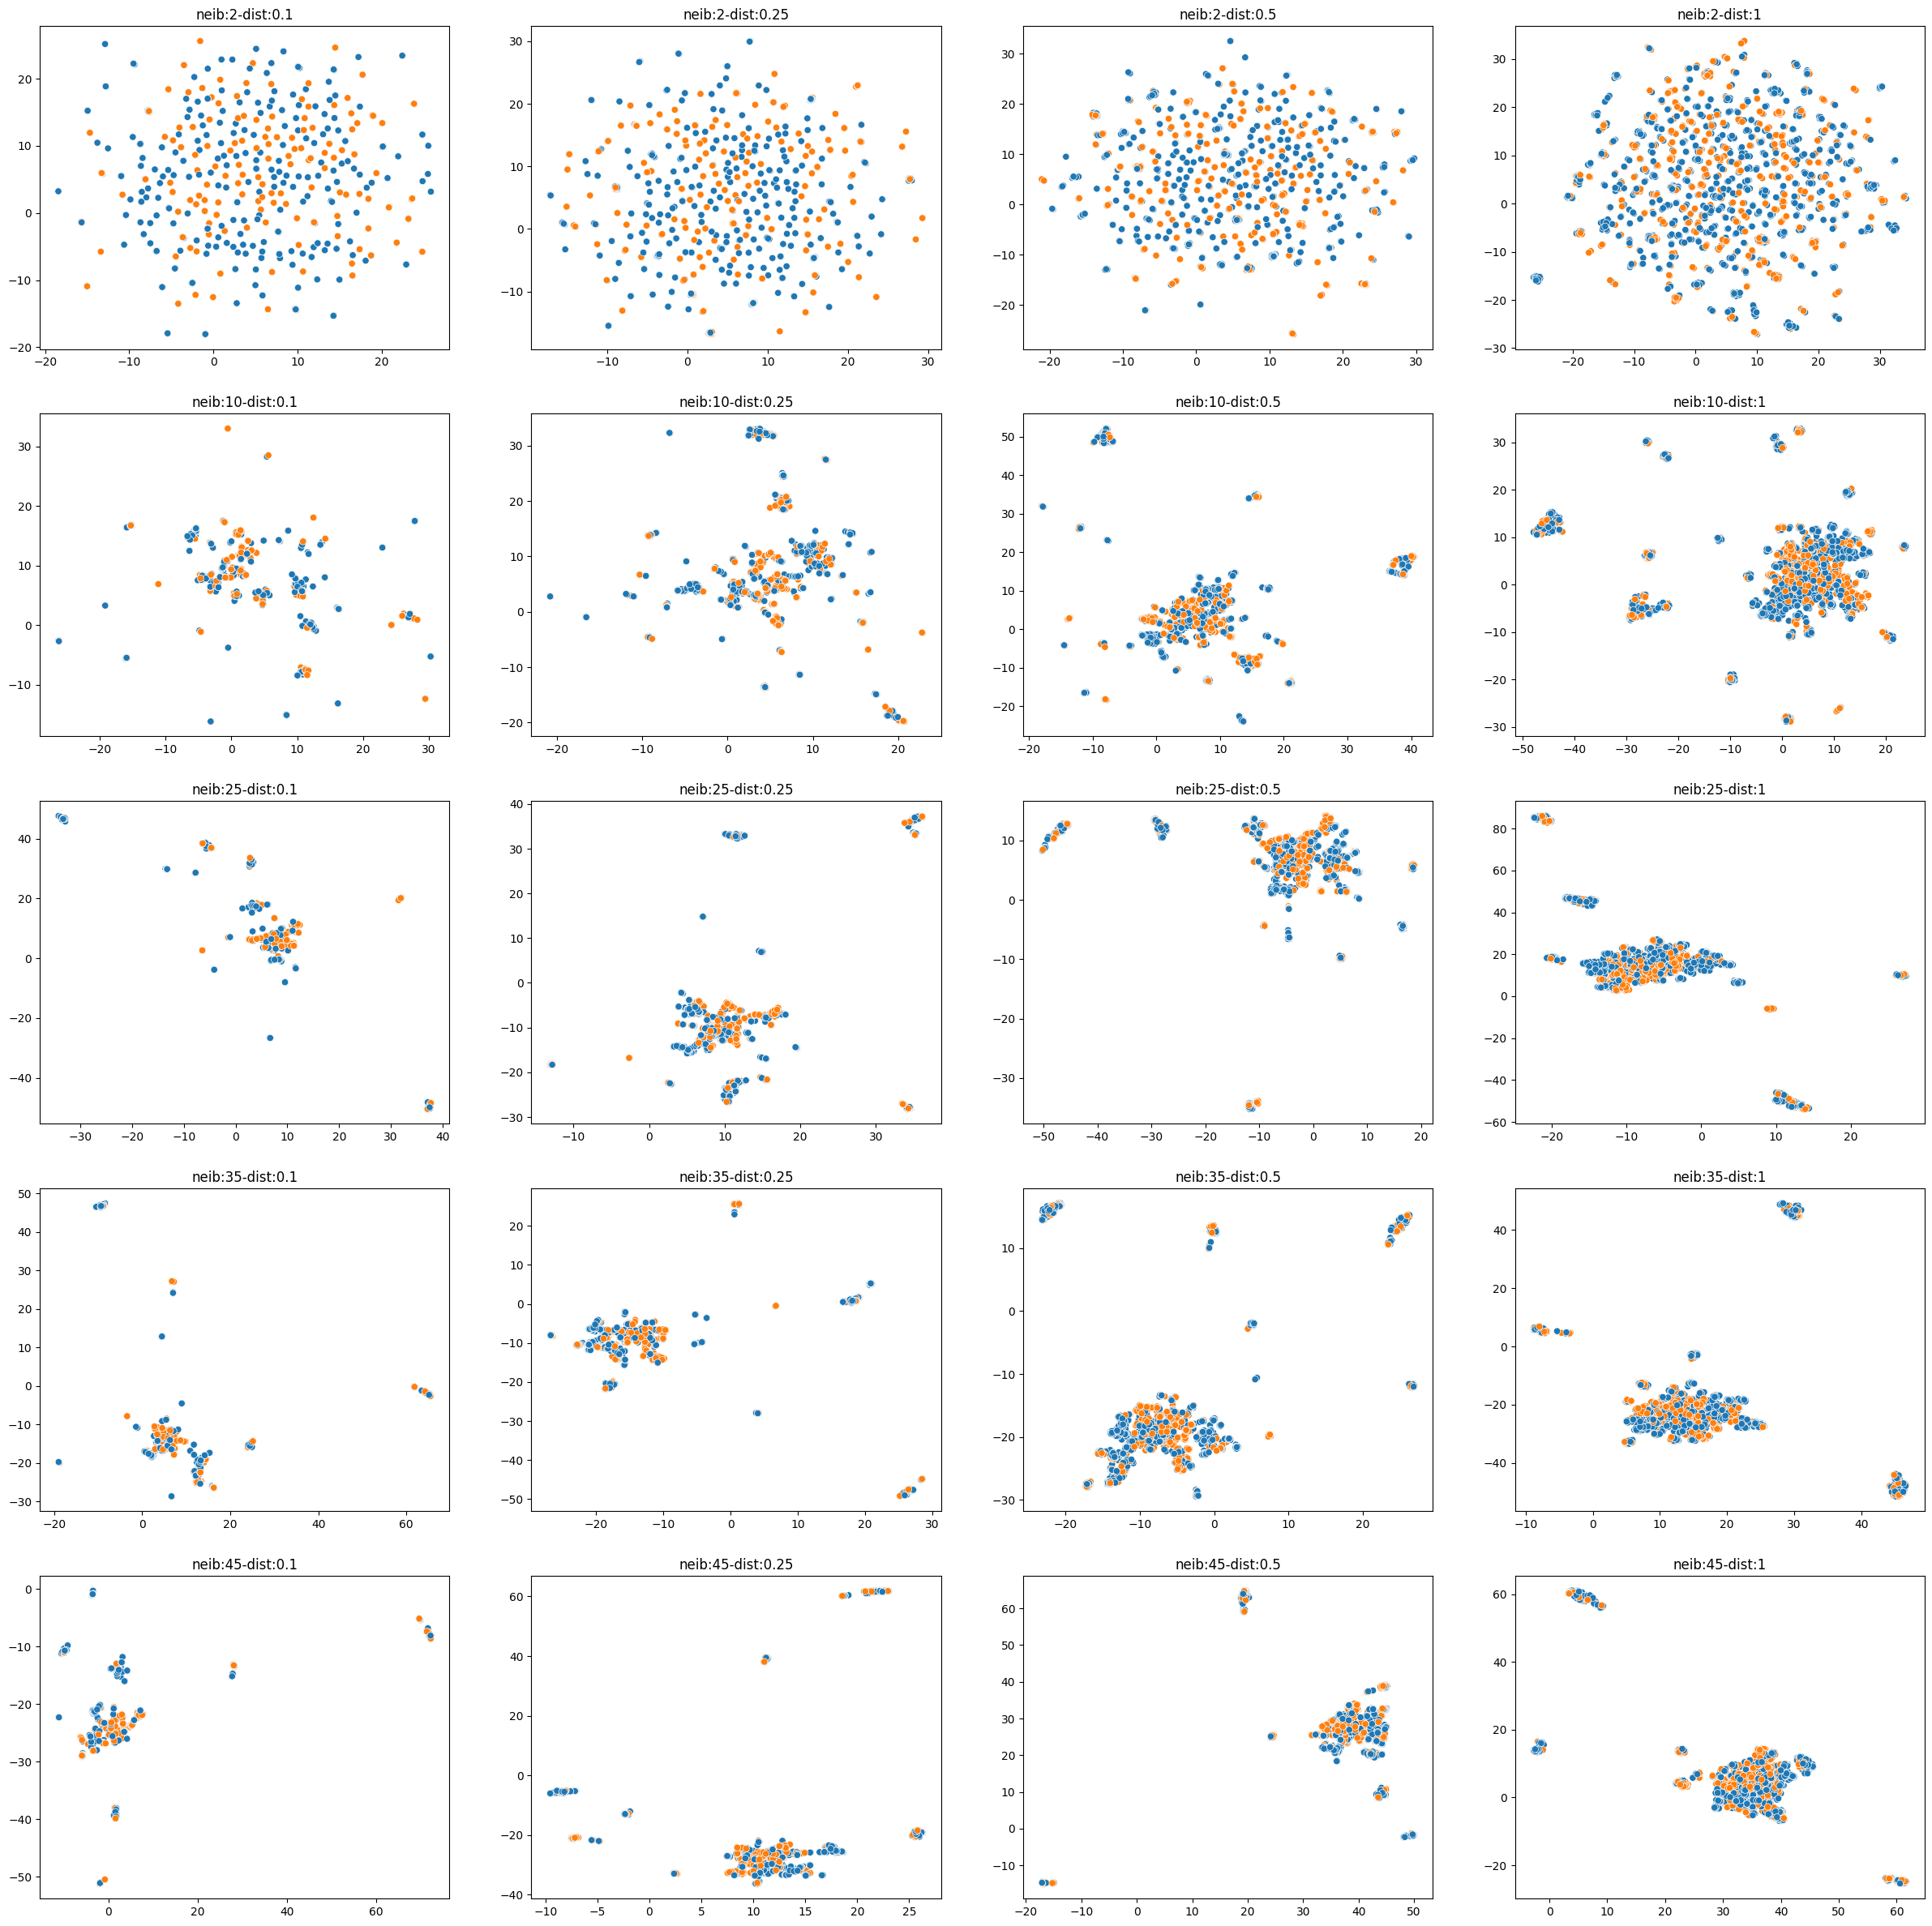

In [13]:
# Set parameters
n_neighbors=[2, 10, 25, 35, 45]
min_dist=[0.1, 0.25, 0.5, 1]
fig, axes = plt.subplots(nrows=5, ncols=4, figsize=(30, 30))

# Create UMAP and plots [ / 8 marks]
for i, n_neighbors_i in enumerate(n_neighbors):
    for j, min_dist_j in enumerate(min_dist):
        
        # create UMAP
        umap_obj = umap.UMAP(
            n_neighbors=n_neighbors_i,
            min_dist=min_dist_j,
            n_components = 2,
            n_epochs = 1000,
            metric = 'cosine',
            low_memory = False,
            init = 'random',
            n_jobs=-1,
            random_state=seed
        )

        # fit umap with train
        umap_obj.fit(TfIDF_train)
        
        # transform train with umap
        TfIDF_train_projected = umap_obj.transform(TfIDF_train)

        # Create plot
        sns.scatterplot(x=TfIDF_train_projected[:, 0], y=TfIDF_train_projected[:, 1], hue=y_train, ax=axes[i, j], legend=False)
        axes[i, j].set_title('neib:{}-dist:{}'.format(n_neighbors_i, min_dist_j))



**Question:** Which paramter would you choose? [ / 2 marks]

**Your Answer: We should choose the parameter that create maximum seperation between elements of the two classes. It is hard to determine the best one because all of them do not reach a good performance. To my eye {10, 0.25} creates the best sepration between the two classes.** 

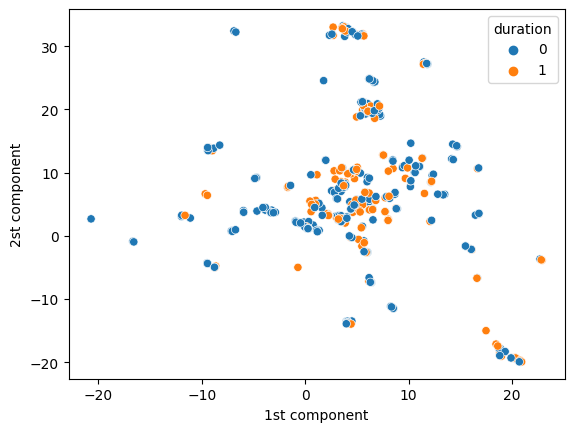

In [14]:
# Choose the paramters that you think are best and apply to test set [ / 4 marks]
# create UMAP
best_n_neighbors = 10
best_min_dist = 0.25
umap_obj = umap.UMAP(
            n_neighbors=best_n_neighbors,
            min_dist=best_min_dist,
            n_components = 2,
            n_epochs = 1000,
            metric = 'cosine',
            low_memory = False,
            init = 'random',
            n_jobs=-1,
            random_state=seed
        )

# fit umap with train
umap_obj.fit(TfIDF_train)

# transform test with umap
TfIDF_test_projected = umap_obj.transform(TfIDF_test)

# Create plot [ /2 marks]
# Plot the two different set of points with different markers and labels [ /4 marks]
sns.scatterplot(x=TfIDF_test_projected[:, 0], y=TfIDF_test_projected[:, 1], hue=y_test)
plt.xlabel('1st component')
plt.ylabel('2st component')
plt.show()


**Question:** How does the plot compare to the PCA one? [ /2 marks]

**Your answer: This is better than PCA one. It separates the two classes better.** 

## Task 2: Benchmarking predictive capabilities of the compressed data [ / 34 marks]

For this task, we will benchmark the predictive capabilities of the compressed data against the original one. 



### Question 2.1 
Train a regularized logistic regression over the original TfIDF train set using l2 regularization. Calculate the AUC score and plot the ROC curve for the original test set.

AUC Score: 0.705


Text(0.5, 1.0, 'AUC Score: 0.705')

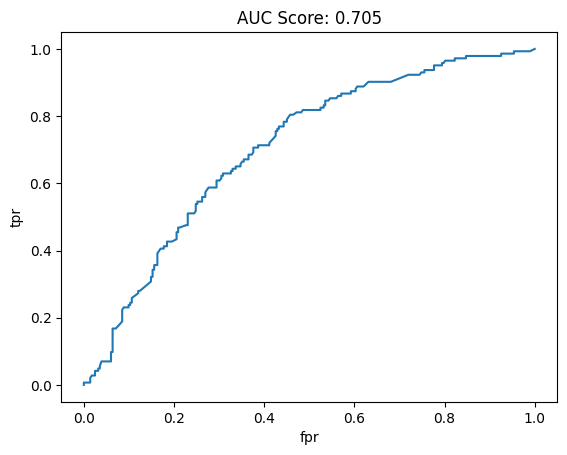

In [15]:
# Train and test using model LogisticRegressionCV [ /3 marks]

X_train = TfIDF_train
X_test = TfIDF_test

cv = StratifiedKFold(n_splits=5)

# Define the model
model = LogisticRegressionCV(Cs=10, cv=cv, penalty='l2', scoring='roc_auc', n_jobs=-1, refit=True, random_state=seed)

# Fit on the training dataset
model.fit(X=X_train, y=y_train)

# Apply to the test dataset
model_y_test_pred = model.predict_proba(X=X_test)

# Plot ROC curve and compute AUC score [ /2 marks]
# Calculate the ROC curve points
fpr, tpr, _ = roc_curve(y_true=y_test, y_score=model_y_test_pred[:, 1], pos_label=1)

# Save the AUC in a variable to display it. Round it first
auc_score = roc_auc_score(y_true=y_test, y_score=model_y_test_pred[:, 1])
auc_score = round(auc_score, 3)
print('AUC Score: {}'.format(auc_score))

# Create and show the plot
plt.plot(fpr, tpr)
plt.xlabel('fpr')
plt.ylabel('tpr')
plt.title('AUC Score: {}'.format(auc_score))

### Question 2.2 
Train a regularized logistic regression over an SVD-reduced dataset (with 13 components) using l2 regularization. Calculate the AUC score and plot the ROC curve for the SVD-transformed test set.

AUC Score: 0.695


Text(0.5, 1.0, 'AUC Score: 0.695')

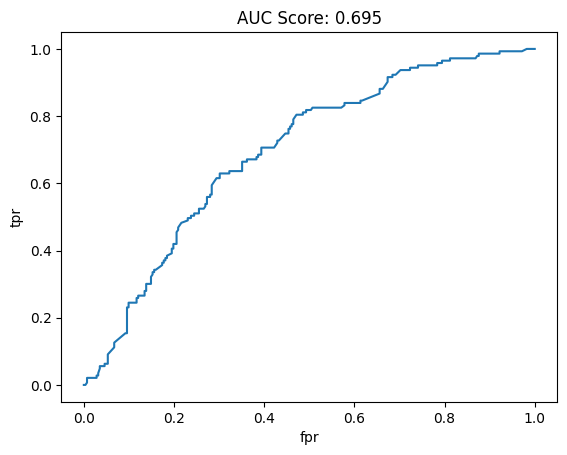

In [16]:
# Apply SVD first [ / 4 marks]
truncated_svd = TruncatedSVD(n_components=13, n_iter=10, random_state=seed)
truncated_svd.fit(TfIDF_train)
X_train = truncated_svd.transform(TfIDF_train)
X_test = truncated_svd.transform(TfIDF_test)

cv = StratifiedKFold(n_splits=5)

# Define the model
model = LogisticRegressionCV(Cs=10, cv=cv, penalty='l2', scoring='roc_auc', n_jobs=-1, refit=True, random_state=seed)

# Fit on the training dataset
model.fit(X=X_train, y=y_train)

# Apply to the test dataset
model_y_test_pred = model.predict_proba(X=X_test)

# Plot ROC curve and compute AUC score [ /2 marks]
# Calculate the ROC curve points
fpr, tpr, _ = roc_curve(y_true=y_test, y_score=model_y_test_pred[:, 1], pos_label=1)

# Save the AUC in a variable to display it. Round it first
auc_score = roc_auc_score(y_true=y_test, y_score=model_y_test_pred[:, 1])
auc_score = round(auc_score, 3)
print('AUC Score: {}'.format(auc_score))

# Create and show the plot
plt.plot(fpr, tpr)
plt.xlabel('fpr')
plt.ylabel('tpr')
plt.title('AUC Score: {}'.format(auc_score))



### Question 2.3 
Train a regularized logistic regression over the UMAP-reduced dataset (with 13 components using the same parameters as Task 1.5) using l2 regularization. Calculate the AUC score and plot the ROC curve for the UMAP-transformed test set.

AUC Score: 0.602


Text(0.5, 1.0, 'AUC Score: 0.602')

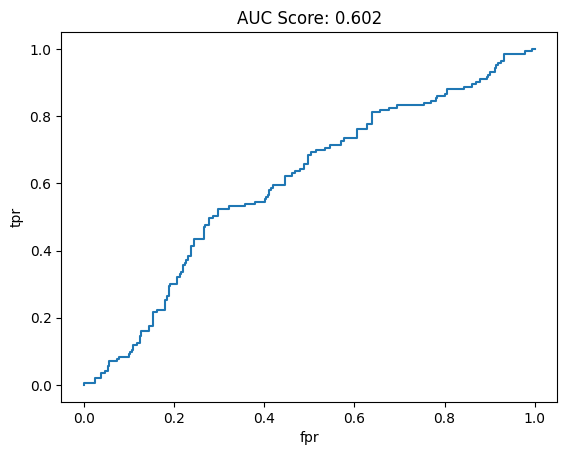

In [17]:
# Apply UMAP first [ / 3 marks]
umap_obj = umap.UMAP(
            n_neighbors=best_n_neighbors,
            min_dist=best_min_dist,
            n_components = 13,
            n_epochs = 1000,
            metric = 'cosine',
            low_memory = False,
            init = 'random',
            n_jobs=-1,
            random_state=seed
        )
umap_obj.fit(TfIDF_train)
X_train = umap_obj.transform(TfIDF_train)
X_test = umap_obj.transform(TfIDF_test)

cv = StratifiedKFold(n_splits=5)

# Define the model
model = LogisticRegressionCV(Cs=10, cv=cv, penalty='l2', scoring='roc_auc', n_jobs=-1, refit=True, random_state=seed)

# Fit on the training dataset
model.fit(X=X_train, y=y_train)

# Apply to the test dataset
model_y_test_pred = model.predict_proba(X=X_test)

# Plot ROC curve and compute AUC score [ /2 marks]
# Calculate the ROC curve points
fpr, tpr, _ = roc_curve(y_true=y_test, y_score=model_y_test_pred[:, 1], pos_label=1)

# Save the AUC in a variable to display it. Round it first
auc_score = roc_auc_score(y_true=y_test, y_score=model_y_test_pred[:, 1])
auc_score = round(auc_score, 3)
print('AUC Score: {}'.format(auc_score))

# Create and show the plot
plt.plot(fpr, tpr)
plt.xlabel('fpr')
plt.ylabel('tpr')
plt.title('AUC Score: {}'.format(auc_score))


### Question 2.4
Train a XGBoost model over the SVD-reduced dataset prepared in Question 2.2. Calculate the AUC score and plot the ROC curve for the SVD-transformed test set. In your model set ``num_boost_round=10`` and ``early_stopping_rounds=2``. You need to do CV using the training dataset, and then get best iteration based on cross-validation results. Finally, train the model on full training dataset with best number of iterations.

Best number of iterations: 6
AUC Score: 0.706


Text(0.5, 1.0, 'AUC Score: 0.706')

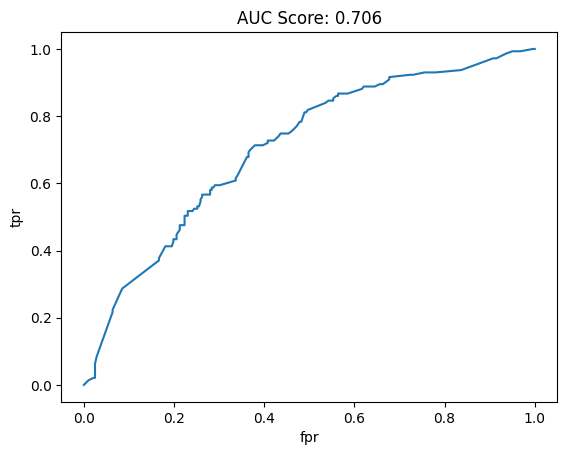

In [18]:
# Define XGBoost parameters
params = {
    "objective": "binary:logistic",
    "eval_metric": "logloss",
    "max_depth": 3,
}

# Apply Truncated SVD
truncated_svd = TruncatedSVD(n_components=13, n_iter=10, random_state=seed)
truncated_svd.fit(TfIDF_train)
X_train = truncated_svd.transform(TfIDF_train)
X_test = truncated_svd.transform(TfIDF_test)

# https://xgboost.readthedocs.io/en/stable/python/python_api.html
# Define cross-validation object

# Perform cross-validation with XGBoost [ \3 marks]
dtrain = xgb.DMatrix(X_train, label=y_train)
dtest = xgb.DMatrix(X_test, label=y_test)

cv_results = xgb.cv(
    params=params,
    dtrain=dtrain,
    num_boost_round=10,
    early_stopping_rounds=2,
    metrics=["auc"],
    stratified=True,
    seed=seed,
)

# Get best iteration based on cross-validation results [\ 1 mark]
best_iteration = cv_results["test-auc-mean"].idxmax()
print("Best number of iterations:", best_iteration+1)
# Train final model on full dataset with best number of iterations [\ 2 mark]
model = xgb.train(
    params=params,
    dtrain=dtrain,
    num_boost_round=best_iteration,
    verbose_eval=False
)

# Predict the probabilities on the test set
model_y_test_pred = model.predict(dtest)

# Compute predicted probabilities on the test set [\ 1 mark]

# Plot ROC curve and compute AUC score [ /2 marks]
# Calculate the ROC curve points
fpr, tpr, _ = roc_curve(y_true=y_test, y_score=model_y_test_pred, pos_label=1)

# Save the AUC in a variable to display it. Round it first
auc_score = roc_auc_score(y_true=y_test, y_score=model_y_test_pred)
auc_score = round(auc_score, 3)
print('AUC Score: {}'.format(auc_score))

# Create and show the plot
plt.plot(fpr, tpr)
plt.xlabel('fpr')
plt.ylabel('tpr')
plt.title('AUC Score: {}'.format(auc_score))

### Question 2.5
Compare the performance of the four models. Which one is the best. [ / 2 marks] 

**Your Answer: 2.1 (0.705), 2.2 (0.695), 2.3 (0.602), 2.4 (0.706). Among them the The XGBoost on Truncated SVD (2.4) obtained the best result. Truncated SVD was expected to do a good job on this dataset since it is so sparse. Also, XGboost is more complex than Linear Regression. The supperior performance seems logical. Alsi it is better that orginal data, although it has 13 component.** 